In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from itertools import product
import warnings
from sklearn.base import clone
import pickle as pkl
import os
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
import numpy as np
from scipy.optimize import dual_annealing
import copy


In [2]:
# Simulate 20 patients: each with a sequence of ΔV and a replanning fraction label
np.random.seed(42)

def simulate_patient_data(n_patients=20, seq_len=30):
    data = []
    for i in range(n_patients):
        volume_changes = np.cumsum(np.random.randn(seq_len))  # synthetic ΔV
        if i < 12:
            replanning_fraction = np.random.randint(5, 30)
        else:
            replanning_fraction = 0
        data.append({'patient_id': i, 'volume': volume_changes, 'label': replanning_fraction})
    return data

patients = simulate_patient_data()


In [3]:
# Load the data
DATA_PATH = '../data/'
all_data = pkl.load(open(os.path.join(DATA_PATH, 'all_data.pkl'), 'rb'))
for patient_id in all_data.keys():
    all_data[patient_id]['data'] = all_data[patient_id]['data'].drop([index for index in all_data[patient_id]['data'].index if 'REPLAN' in index or 'RT' in index or 'PT' in index])
# print(np.array(all_data['001']['data']['volume difference to pCT [cm^3]'].values))

patients = [{'patient_id': int(patient_id.lstrip('0'))-1,
             'volume': all_data[patient_id]['data']['volume difference to pCT [%]'].values,
             'label': all_data[patient_id]['label'][0]
            }
             for patient_id in all_data.keys()]



In [ ]:
def extract_features(volumes, variant='A', last_n=5):
    x_all = np.arange(len(volumes)).reshape(-1, 1)
    y_all = np.array(volumes).reshape(-1, 1)

    slope_all = LinearRegression().fit(x_all, y_all).coef_[0][0]
    slope_last = LinearRegression().fit(x_all[-last_n:], y_all[-last_n:]).coef_[0][0]
    mean_last_two = np.mean(volumes[-2:])

    features = {
        'A': [mean_last_two, slope_last, slope_all],
        'B': [mean_last_two, slope_last],
        'C': [mean_last_two, slope_all],
        'D': [mean_last_two],
    }
    return features[variant]


In [91]:
def custom_loss(y_true, y_pred, alpha_late, beta_fn, gamma_fp):
    total = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0:
            if yp > 0:
                total += beta_fn # False positive
        else:
            if yp == 0:
                total += gamma_fp # False negative
            elif yp > yt:
                total += alpha_late * (yp - yt)**2 # Late replanning
            else:
                total += (1-alpha_late)*(yt - yp)**2 # Early replanning
    return total # / len(y_true)

# def custom_loss(y_true, y_pred, alpha_late, beta_fn, gamma_fp):
#     total = 0
#     for yt, yp in zip(y_true, y_pred):
#         if yt == 0:
#             if yp > 0:
#                 total += (33-yp)**2 # False positive
#         else:
#             if yp == 0:
#                 total += (33-yt)**2 # False negative
#             elif yp > yt:
#                 total += alpha_late * (yp - yt)**2 # Late replanning
#             else:
#                 total += (1-alpha_late)*(yt - yp)**2 # Early replanning
#     return total # / len(y_true)

In [125]:
def sequential_predict(patient_volume, model, feature_variant, min_t=5, max_t=30):
    """
    Simulate sequential inference and stop as soon as the model predicts replanning.
    """
    for t in range(min_t, max_t + 1):
        partial_volumes = patient_volume[:t]
        features = extract_features(partial_volumes, feature_variant)
        prediction = model.predict([features])[0]
        if prediction > 0:
            return t, prediction
    return 0, 0  # No replanning predicted at any time


In [129]:
class ThresholdModel(BaseEstimator, ClassifierMixin):
    def __init__(self, custom_loss_fn, search_grid=None, min_t=5, max_t=50,
                 alpha_late=2.0, beta_fn=20.0, gamma_fp=1.0):
        self.thresholds = None
        self.search_grid = search_grid if search_grid is not None else np.linspace(-6, 0, 50)
        self.min_t = min_t
        self.max_t = max_t
        self.alpha_late = alpha_late
        self.beta_fn = beta_fn
        self.gamma_fp = gamma_fp
        self.custom_loss_fn = custom_loss_fn

    def fit(self, X_seqs, y_true):
        """
        X_seqs: List of sequences (one per patient), each sequence is a list of feature vectors (t=5 to 30)
        y_true: True replanning labels (0 if no replanning, or fraction of replanning)
        """
        
        bounds = [(-6, 0) for _ in range(len(X_seqs[0][0]))]
        best_thresh = dual_annealing(lambda x: self.custom_loss_fn(y_true, [self._predict_single(x_seq, x) for x_seq in X_seqs], self.alpha_late, self.beta_fn, self.gamma_fp),
                                            bounds=bounds, maxiter=1000).x


        self.thresholds = np.array(best_thresh)
        return self

    def _predict_single(self, x_seq, thresholds):
        """
        Returns the earliest time t (as fraction index) where all features < thresholds.
        """
        for t, x in enumerate(x_seq, start=self.min_t):
            if (np.array(x) < thresholds).all():
                return t
        return 0

    def predict(self, X_seqs):
        return [self._predict_single(x_seq, self.thresholds) for x_seq in X_seqs]


In [99]:
X_train = [[extract_features(p['volume'][:t], 'D') for t in range(5, 31)] for p in train_patients]
y_train = [p['label'] for p in train_patients]
model = ThresholdModel(custom_loss_fn=custom_loss, search_grid=None, min_t=5, max_t=36)
model.alpha_late = 0.8
model.beta_fn = 900
model.gamma_fp = 300
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
print(model.thresholds)

[-3.65740161]


In [108]:
def calculate_f1(y_true, y_pred):
    """
    Calculate F1 score for the given true and predicted labels.
    """
    tp = 0
    fp = 0
    fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt > 0 and yp > 0:
            tp += 1
        elif yt == 0 and yp > 0:
            fp += 1
        elif yt > 0 and yp == 0:
            fn += 1

    if tp + fp + fn == 0:
        return 0.0

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

def calculate_balanced_accuracy(y_true, y_pred):
    """
    Calculate balanced accuracy for the given true and predicted labels.
    """
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt > 0 and yp > 0:
            tp += 1
        elif yt == 0 and yp > 0:
            fp += 1
        elif yt > 0 and yp == 0:
            fn += 1
        else:
            tn += 1

    sensitivity = tp / (tp + fn) if tp + fn > 0 else 0
    specificity = tn / (tn + fp) if tn + fp > 0 else 0

    return (sensitivity + specificity) / 2 if sensitivity + specificity > 0 else 0

# Setup
feature_variants = ['A', 'B', 'C', 'D']

model_types = {
    'THRESH': ThresholdModel(custom_loss_fn=custom_loss),
    # 'RF': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    # 'LR': LogisticRegression(max_iter=1000)
}
# loss_params_grid = list(product([1, 2], [2, 5], [0.5, 1]))  # (alpha_late, beta_fn, gamma_fp)
loss_params_grid = list(product([0.5, 0.7, 0.8, 0.9], [300, 600, 900], [300, 600, 900]))  # (alpha_late, beta_fn, gamma_fp)

outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
y_all = [p['label'] for p in patients]

summary_rows = []

for train_idx, test_idx in outer_cv.split(np.zeros(len(y_all)), y_all):
    train_patients = [patients[i] for i in train_idx]
    test_patients = [patients[i] for i in test_idx]

    best_score = np.inf
    best_f1 = 0
    best_ba = 0
    best_model = None
    best_variant = None
    best_params = None
    best_model_name = None

    for variant in feature_variants:
        for model_name, model_obj in model_types.items():
            print(f"Training {model_name} with variant {variant}...")
            for alpha_late, beta_fn, gamma_fp in loss_params_grid:
                if beta_fn <= gamma_fp:
                    continue
                # print(f"  Loss params: alpha_late={alpha_late}, beta_fn={beta_fn}, gamma_fp={gamma_fp}")

                y_train = [p['label'] for p in train_patients]

                # ThresholdModel: needs sequential features
                if model_name == 'THRESH':
                    X_train = [[extract_features(p['volume'][:t], variant) for t in range(5, 36)] for p in train_patients]
                    model = clone(model_obj)
                    model.alpha_late = alpha_late
                    model.beta_fn = beta_fn
                    model.gamma_fp = gamma_fp
                    model.fit(X_train, y_train)
                    y_pred_train = model.predict(X_train)
                else:
                    # Other models (non-sequential)
                    X_train = [extract_features(p['volume'], variant) for p in train_patients]
                    model = clone(model_obj)
                    model.fit(X_train, y_train)
                    y_pred_train = model.predict(X_train)

                score = custom_loss(y_train, y_pred_train, alpha_late, beta_fn, gamma_fp)
                f1 = calculate_f1(y_train, y_pred_train)
                ba = calculate_balanced_accuracy(y_train, y_pred_train)

                if f1 > best_f1:#score < best_score:
                    best_score = score
                    best_ba = ba
                    best_f1 = f1
                    best_model = copy.deepcopy(model)
                    best_variant = variant
                    best_params = (alpha_late, beta_fn, gamma_fp)
                    best_model_name = model_name
                elif f1 == best_f1:
                    if ba > best_ba:
                        best_ba = ba
                        best_model = copy.deepcopy(model)
                        best_variant = variant
                        best_params = (alpha_late, beta_fn, gamma_fp)
                        best_model_name = model_name


    # --- Evaluation on outer test set ---
    y_true_seq = []
    y_pred_seq = []
    t_detected = []

    for patient in test_patients:
        y_true = patient['label']

        if best_model_name == 'THRESH':
            X_seq = [extract_features(patient['volume'][:t], best_variant) for t in range(5, 36)]
            pred_label = best_model.predict([X_seq])[0]
            t_pred = pred_label
        else:
            features = extract_features(patient['volume'], best_variant)
            pred_label = best_model.predict([features])[0]
            t_pred = 0 if pred_label == 0 else 30  # assume full length detection

        y_true_seq.append(y_true)
        y_pred_seq.append(pred_label)
        t_detected.append(t_pred)

    summary_rows.append({
        'model': best_model_name,
        'features': best_variant,
        'params': best_params,
        'custom_loss': custom_loss(y_true_seq, y_pred_seq, *best_params),
        'f1_macro': calculate_f1(y_true_seq, y_pred_seq),
        'balanced_acc': calculate_balanced_accuracy(y_true_seq, y_pred_seq),
        'avg_detection_time': np.mean([t for t in t_detected if t > 0])
    })

# Compile summary
summary_df = pd.DataFrame(summary_rows)
display(summary_df)


Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...
Training THRESH with variant A...
Training THRESH with variant B...
Training THRESH with variant C...
Training THRESH with variant D...


,model,features,params,custom_loss,f1_macro,balanced_acc,avg_detection_time
0,THRESH,A,"(0.5, 600, 300)",42.5,1.000000,1.00,8.0
1,THRESH,A,"(0.5, 900, 600)",904.5,0.800000,0.50,11.0
2,THRESH,A,"(0.5, 600, 300)",109.0,1.000000,1.00,9.0
3,THRESH,A,"(0.5, 600, 300)",184.5,1.000000,1.00,8.0
4,THRESH,A,"(0.5, 600, 300)",300.0,0.666667,0.75,23.0
5,THRESH,A,"(0.5, 600, 300)",304.5,0.666667,0.75,19.0
6,THRESH,A,"(0.5, 600, 300)",300.0,0.666667,0.75,16.0


In [ ]:
from sklearn.model_selection import StratifiedKFold
import copy, numpy as np, pandas as pd
from sklearn.base import clone

outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
y_all    = [p['label'] for p in patients]

summary_rows = []

for train_idx, test_idx in outer_cv.split(np.zeros(len(y_all)), y_all):
    print(f'Outer CV fold: {train_idx} / {test_idx}')
    train_patients = [patients[i] for i in train_idx]
    test_patients  = [patients[i] for i in test_idx]

    # best-of-grid trackers
    best_f1, best_ba = -np.inf, -np.inf
    best_conf, best_model = None, None   # (variant, α,β,γ)

    for variant in feature_variants:
        for (alpha_late, beta_fn, gamma_fp) in loss_params_grid:
            if beta_fn <= gamma_fp:
                continue

            # ----- INNER  LOOCV -----
            tp = fp = fn = tn = 0
            for loo_idx, val_patient in enumerate(train_patients):
                # print(f'  Inner CV fold: {loo_idx} / {len(train_patients)}')

                # build inner-training set  = all except val_patient
                inner_train   = [p for k, p in enumerate(train_patients) if k != loo_idx]
                y_inner_train = [p['label'] for p in inner_train]

                X_inner_train = [[extract_features(p['volume'][:t], variant)
                                  for t in range(5, 36)] for p in inner_train]
                X_val         = [[extract_features(val_patient['volume'][:t], variant)
                                  for t in range(5, 36)]]

                model = ThresholdModel(custom_loss_fn=custom_loss,
                                       alpha_late=alpha_late,
                                       beta_fn   =beta_fn,
                                       gamma_fp  =gamma_fp)
                model.fit(X_inner_train, y_inner_train)
                y_pred_val = model.predict(X_val)[0]
                y_true_val = val_patient['label']

                # accumulate confusion counts
                if y_true_val > 0 and y_pred_val > 0:
                    tp += 1
                elif y_true_val == 0 and y_pred_val > 0:
                    fp += 1
                elif y_true_val > 0 and y_pred_val == 0:
                    fn += 1
                else:
                    tn += 1

            # compute mean F1 & BA over the LOOCV rounds
            precision = tp / (tp+fp) if tp+fp else 0
            recall    = tp / (tp+fn) if tp+fn else 0
            f1_mean   = 2*precision*recall/(precision+recall) if precision+recall else 0
            sens      = recall
            spec      = tn / (tn+fp) if tn+fp else 0
            ba_mean   = (sens+spec)/2 if sens+spec else 0

            # choose best config
            if f1_mean > best_f1 or (f1_mean == best_f1 and ba_mean > best_ba):
                best_f1, best_ba = f1_mean, ba_mean
                best_conf        = (variant, alpha_late, beta_fn, gamma_fp)

    # ----- REFIT best config on *all* outer-training patients -----
    variant, alpha_late, beta_fn, gamma_fp = best_conf
    X_train_full  = [[extract_features(p['volume'][:t], variant)
                      for t in range(5, 36)] for p in train_patients]
    y_train_full  = [p['label'] for p in train_patients]

    best_model = ThresholdModel(custom_loss_fn=custom_loss,
                                alpha_late=alpha_late,
                                beta_fn   =beta_fn,
                                gamma_fp  =gamma_fp)
    best_model.fit(X_train_full, y_train_full)

    # ----- EVALUATE on outer-test patients -----
    y_true, y_pred, det_time = [], [], []
    for patient in test_patients:
        X_seq = [[extract_features(patient['volume'][:t], variant)
                  for t in range(5, 36)]]
        pred  = best_model.predict(X_seq)[0]
        y_true.append(patient['label'])
        y_pred.append(pred)
        det_time.append(pred)

    summary_rows.append({
        'variant'  : variant,
        'params'   : (alpha_late, beta_fn, gamma_fp),
        'f1_outer' : calculate_f1(y_true, y_pred),
        'ba_outer' : calculate_balanced_accuracy(y_true, y_pred),
        'avg_det'  : np.mean([t for t in det_time if t > 0])
    })

# --------- results ----------
summary_df = pd.DataFrame(summary_rows)
display(summary_df)


Outer CV fold: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 20] / [ 0  5 17]
  Inner CV fold: 0 / 18
  Inner CV fold: 1 / 18
  Inner CV fold: 2 / 18
  Inner CV fold: 3 / 18
  Inner CV fold: 4 / 18
  Inner CV fold: 5 / 18
  Inner CV fold: 6 / 18
  Inner CV fold: 7 / 18
  Inner CV fold: 8 / 18
  Inner CV fold: 9 / 18
  Inner CV fold: 10 / 18
  Inner CV fold: 11 / 18
  Inner CV fold: 12 / 18
  Inner CV fold: 13 / 18
  Inner CV fold: 14 / 18
  Inner CV fold: 15 / 18
  Inner CV fold: 16 / 18
  Inner CV fold: 17 / 18
  Inner CV fold: 0 / 18
  Inner CV fold: 1 / 18
  Inner CV fold: 2 / 18
  Inner CV fold: 3 / 18
  Inner CV fold: 4 / 18
  Inner CV fold: 5 / 18
  Inner CV fold: 6 / 18
  Inner CV fold: 7 / 18
  Inner CV fold: 8 / 18
  Inner CV fold: 9 / 18
  Inner CV fold: 10 / 18
  Inner CV fold: 11 / 18
  Inner CV fold: 12 / 18
  Inner CV fold: 13 / 18
  Inner CV fold: 14 / 18
  Inner CV fold: 15 / 18
  Inner CV fold: 16 / 18
  Inner CV fold: 17 / 18
  Inner CV fold: 0 / 18
  Inner CV f

,variant,params,f1_outer,ba_outer,avg_det
0,D,"(0.5, 900, 300)",1.000000,1.00,8.0
1,D,"(0.5, 600, 300)",0.500000,0.25,16.0
2,D,"(0.8, 600, 300)",1.000000,1.00,9.0
3,D,"(0.8, 900, 600)",1.000000,1.00,18.0
4,D,"(0.7, 900, 300)",0.666667,0.75,33.0
5,D,"(0.8, 600, 300)",1.000000,1.00,22.0
6,D,"(0.9, 900, 600)",0.666667,0.75,15.0


In [126]:
summary_df['model'] = 'THRESH'
summary_df['f1_macro'] = summary_df['f1_outer']


In [130]:
# Select best combination by lowest mean custom loss
grouped = summary_df.groupby(['model', 'features', 'params']).mean()
# Most frequent feature param combination
grouped['count'] = summary_df.groupby(['model', 'features', 'params']).size()

best_combo = grouped['count'].idxmax()
best_model_name, best_variant, best_params = best_combo
best_combco_avg_f1 = summary_df[(summary_df['model'] == best_model_name) & (summary_df['features'] == best_variant) & (summary_df['params'] == best_params)]['f1_macro'].mean()

print(f"Best overall: {best_model_name} with features {best_variant} and params {best_params} with mean f1 {best_combco_avg_f1:.4f}")

# Retrain final model on all patients
X_full =  [[extract_features(p['volume'][:t], best_variant) for t in range(5, 36)] for p in patients]
y_full = [p['label'] for p in patients]
final_model = ThresholdModel(custom_loss_fn=custom_loss)
final_model.alpha_late = best_params[0]
final_model.beta_fn = best_params[1]
final_model.gamma_fp = best_params[2]
final_model.fit(X_full, y_full)
print(f"Final model trained with {best_model_name} using features {best_variant} and params {best_params} has thresholds {final_model.thresholds}.")



Best overall: THRESH with features D and params (0.8, 600, 300) with mean f1 1.0000
Final model trained with THRESH using features D and params (0.8, 600, 300) has thresholds [-2.9958735].


True: 8, Pred: 6
True: 12, Pred: 16
True: 17, Pred: 10
True: 22, Pred: 19
True: 22, Pred: 0
True: 19, Pred: 11
True: 10, Pred: 11
True: 21, Pred: 11
True: 17, Pred: 5
True: 26, Pred: 11
True: 0, Pred: 0
True: 22, Pred: 22
True: 0, Pred: 0
True: 23, Pred: 18
True: 0, Pred: 0
True: 23, Pred: 18
True: 0, Pred: 0
True: 0, Pred: 0
True: 0, Pred: 0
True: 16, Pred: 16
True: 0, Pred: 18
3.142857142857143
f1: 0.9285714285714286
balanced acc: 0.8928571428571428
custom loss: 1042.6


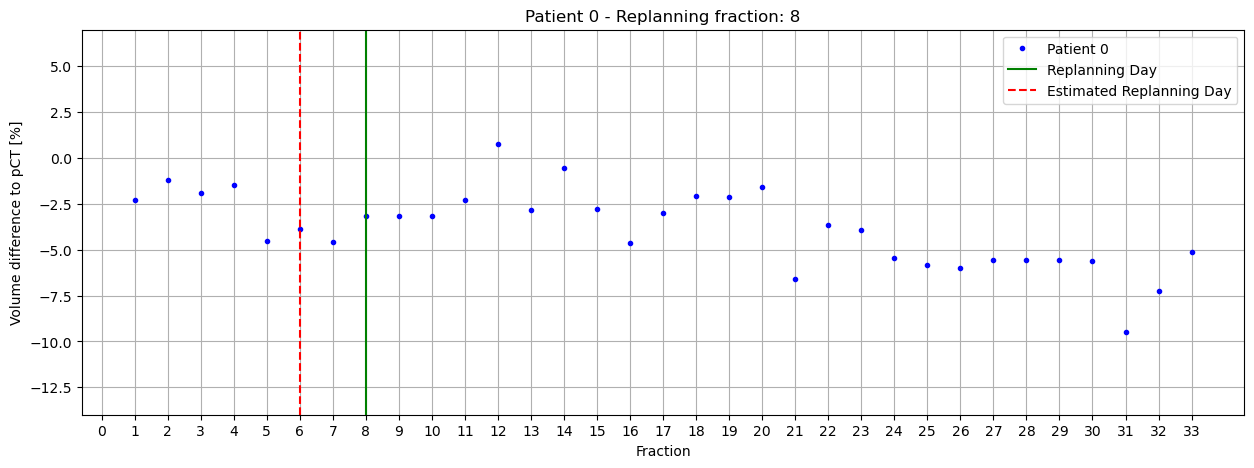

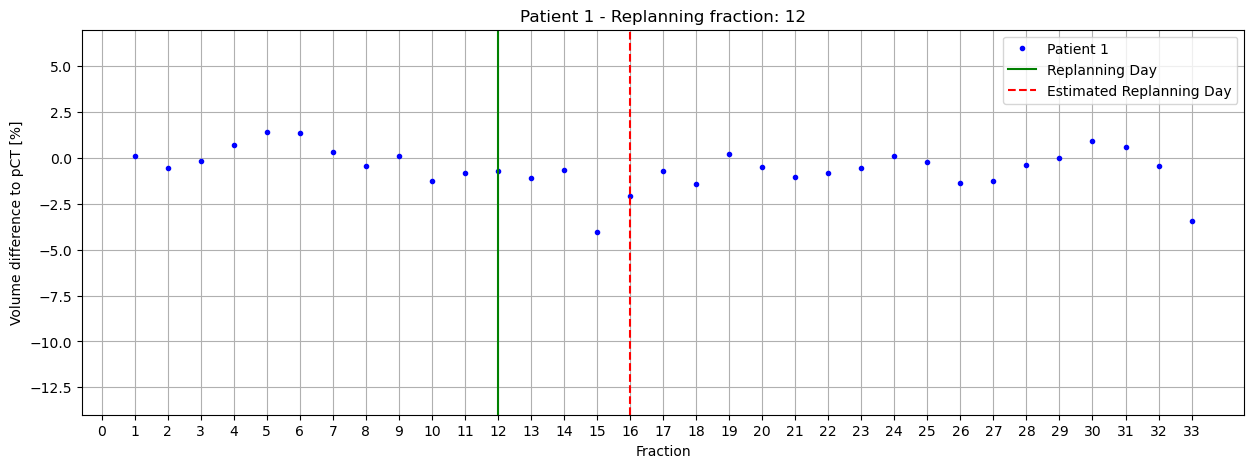

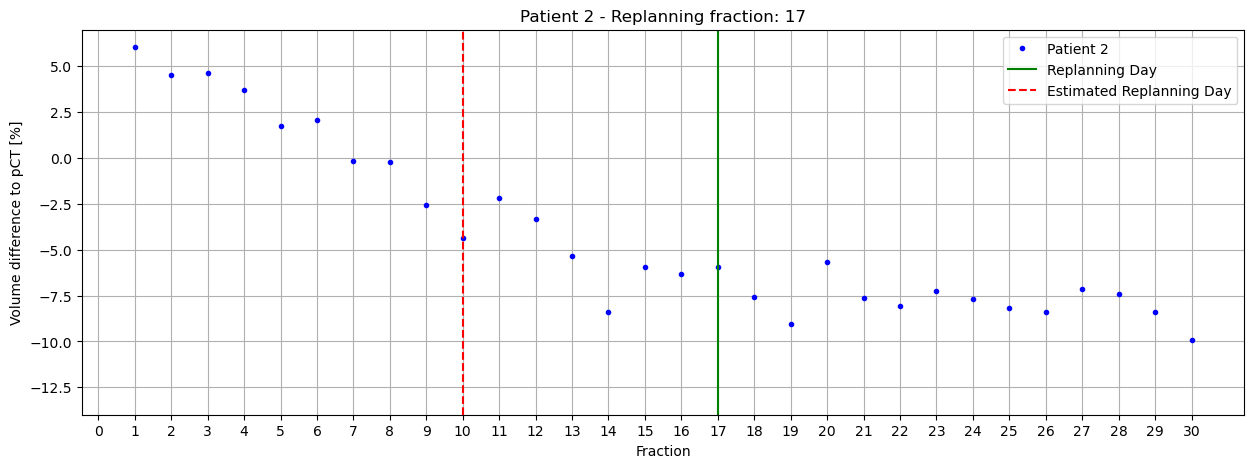

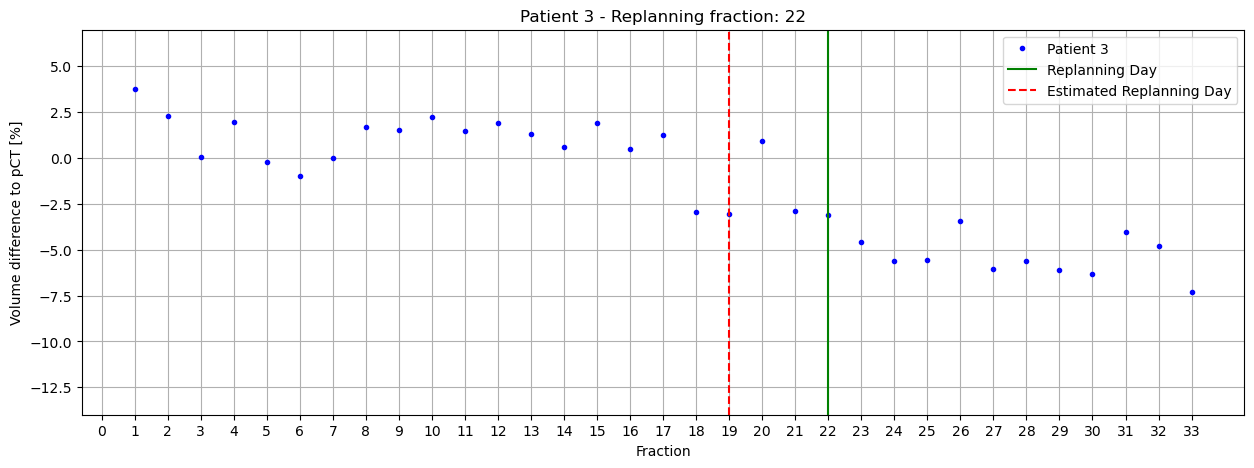

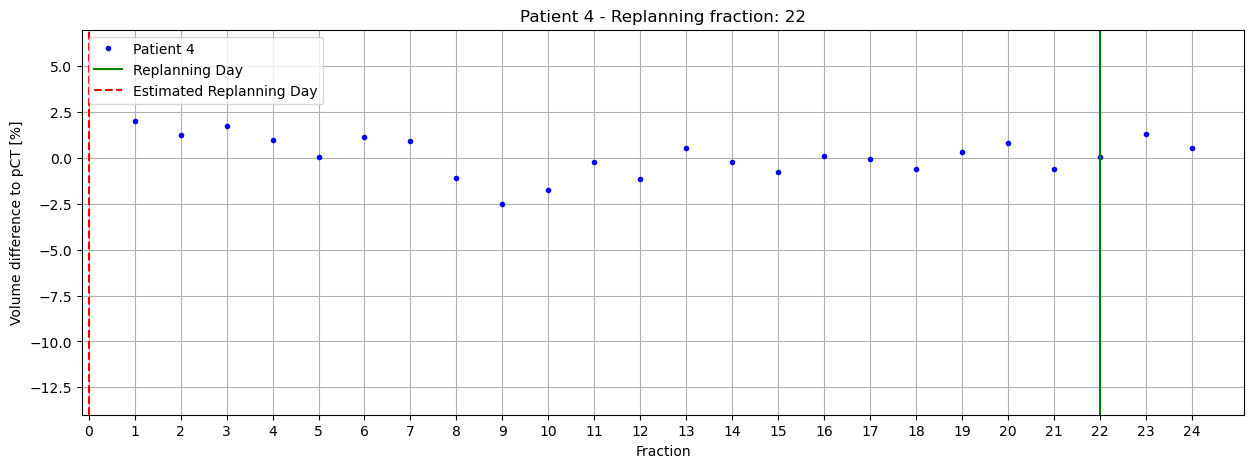

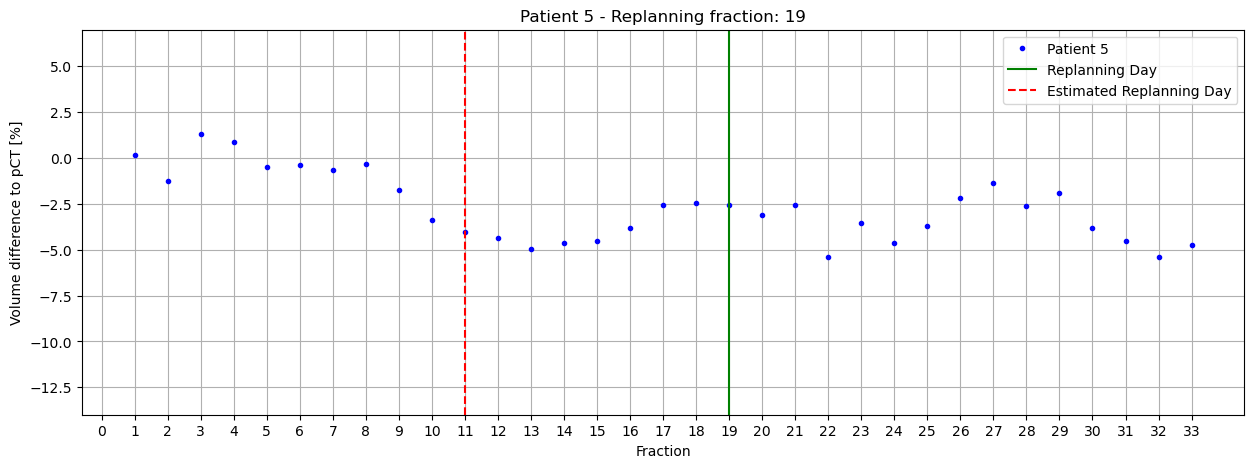

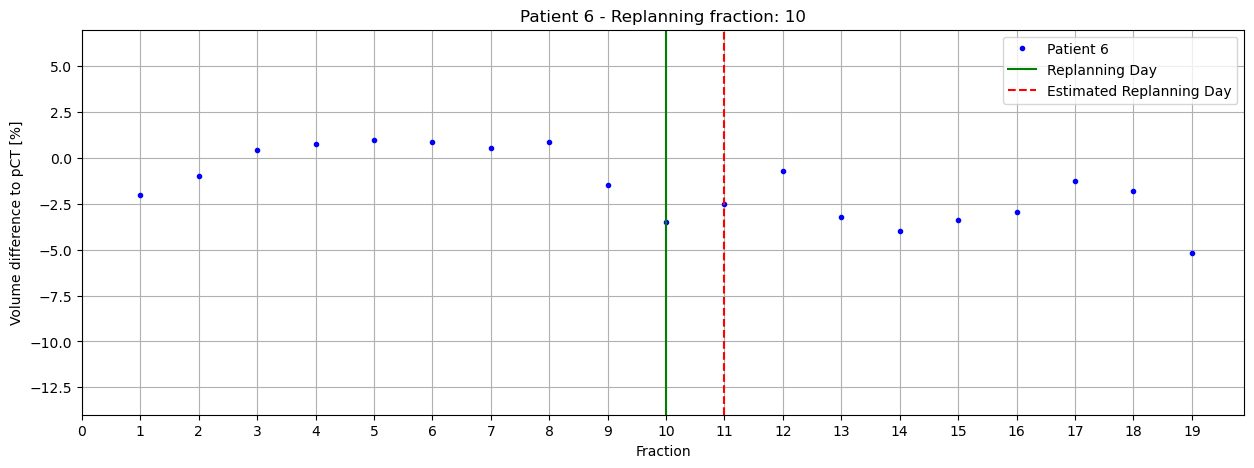

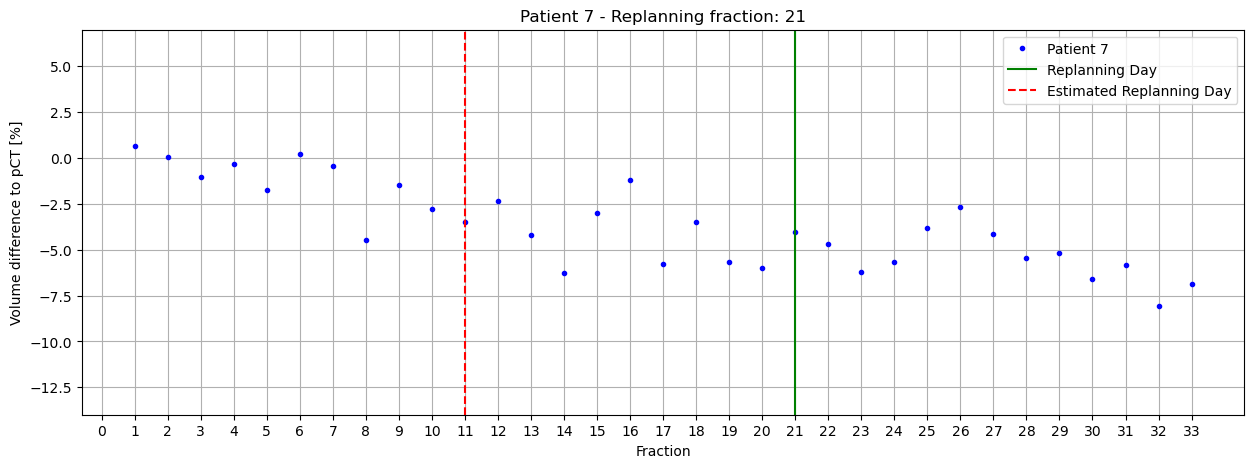

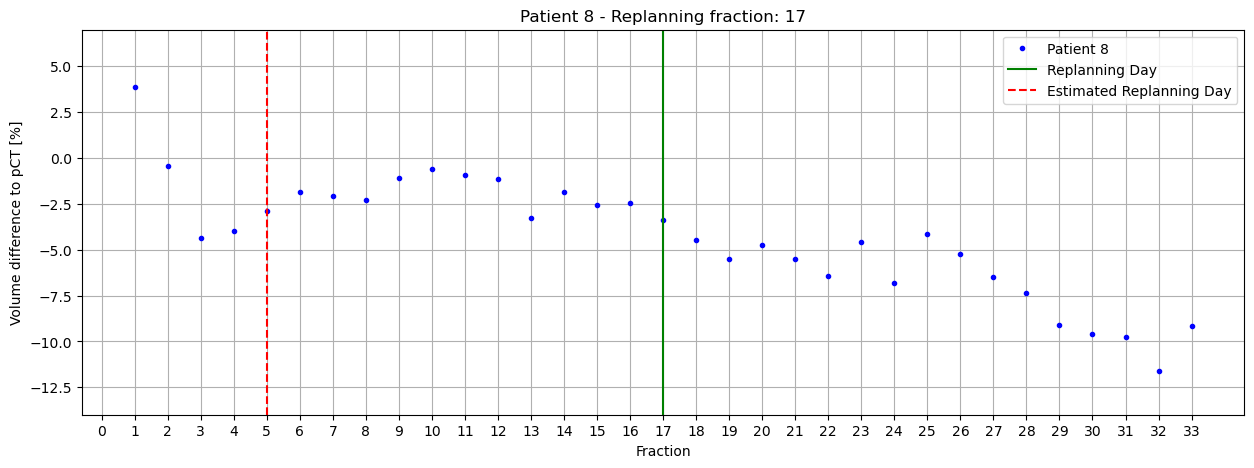

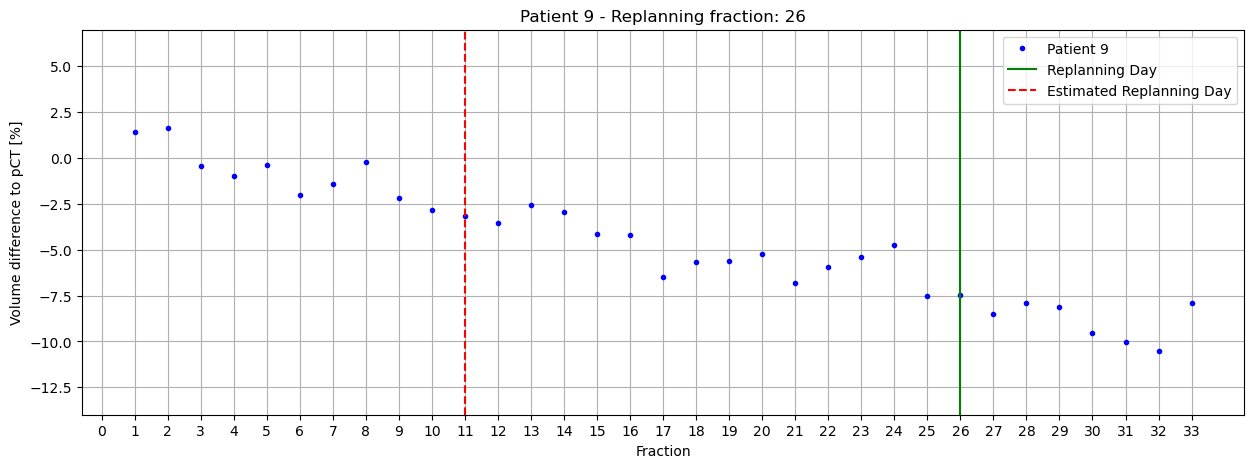

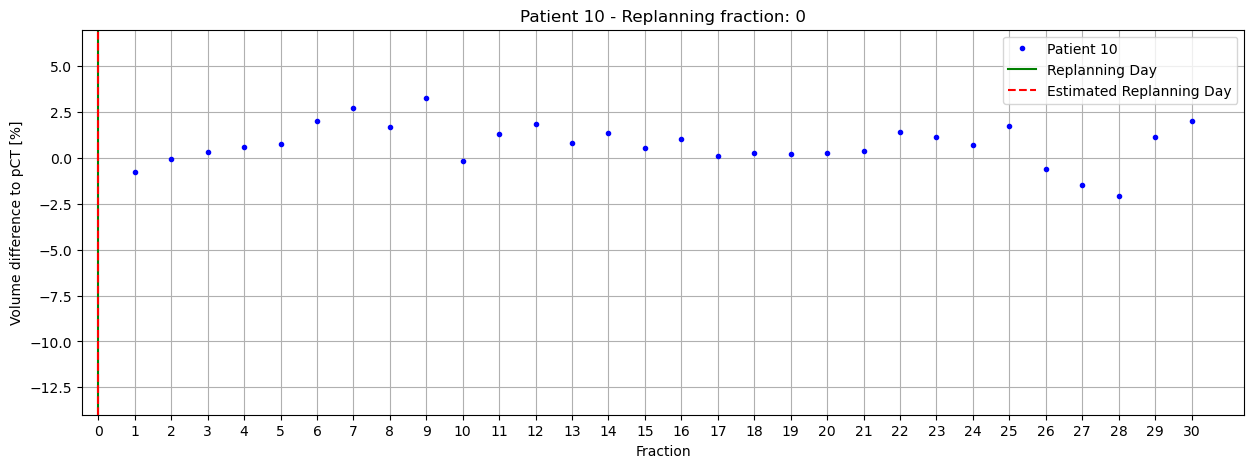

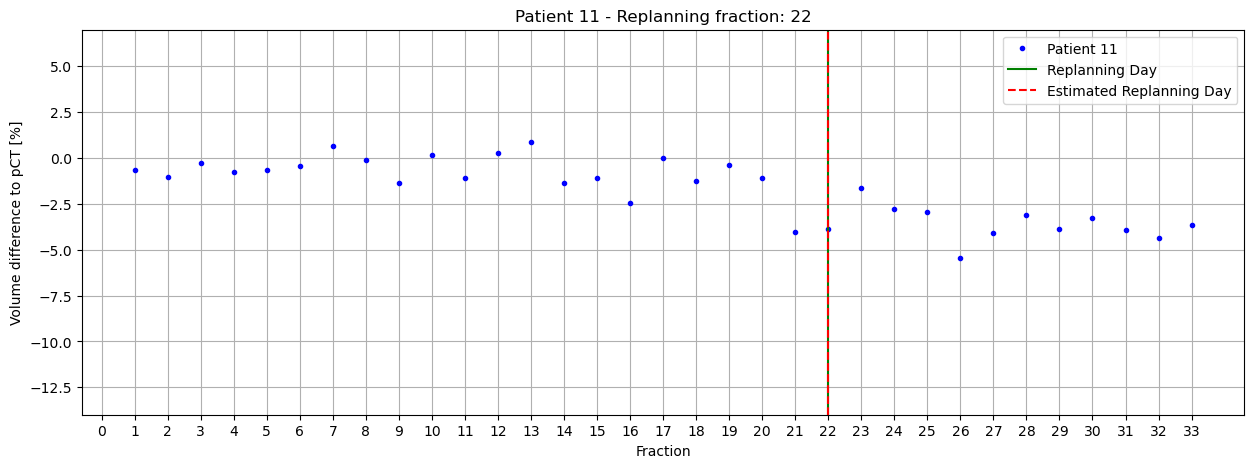

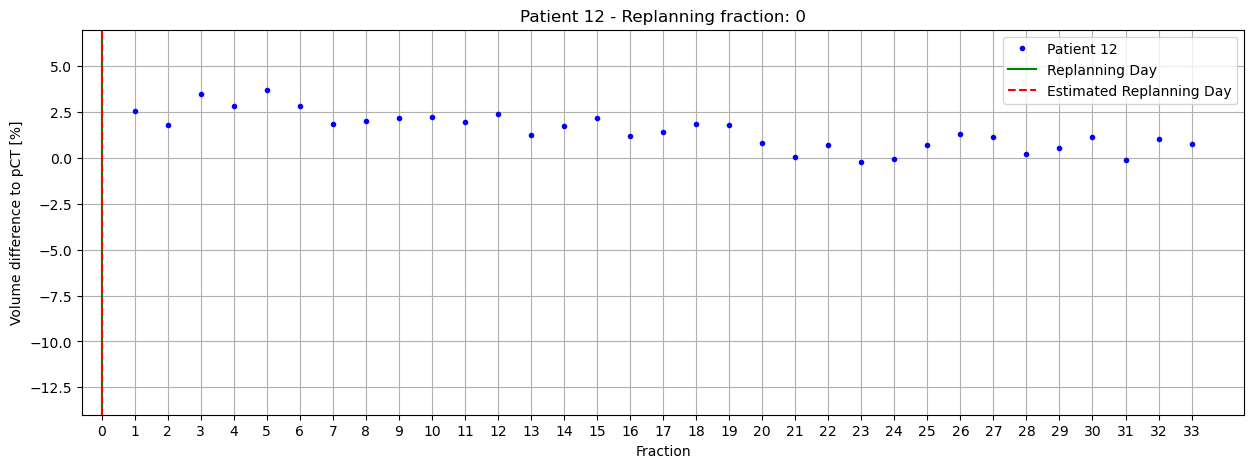

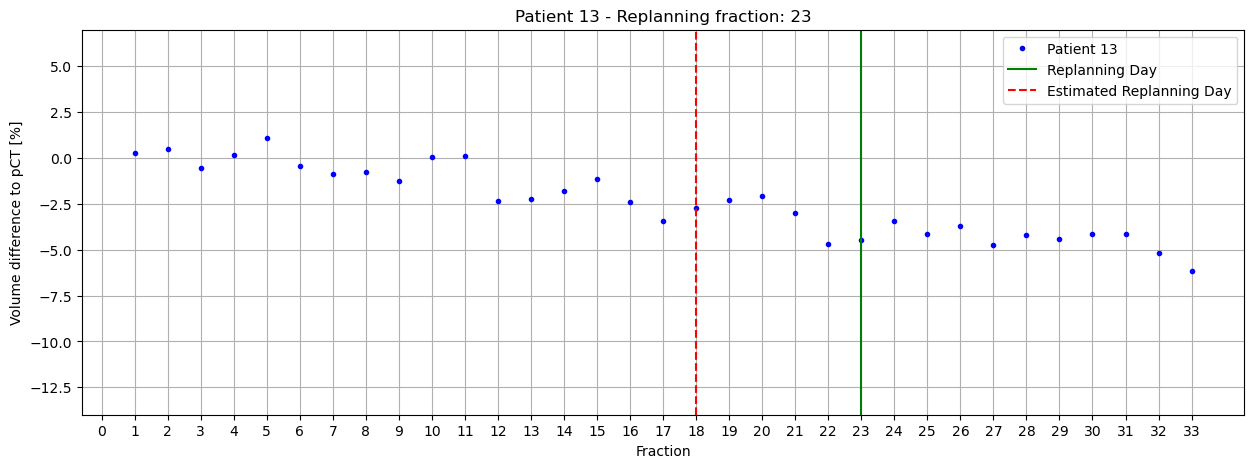

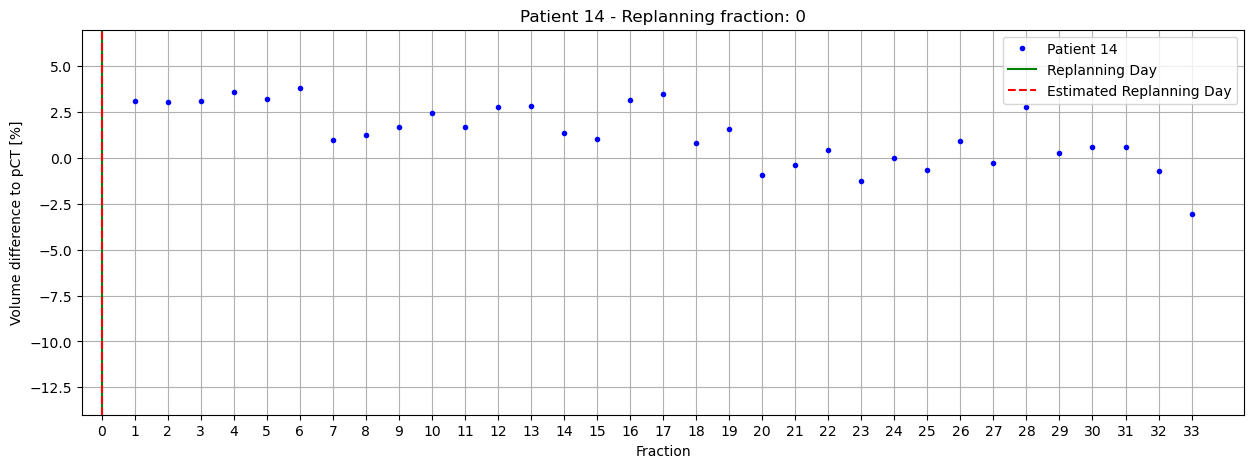

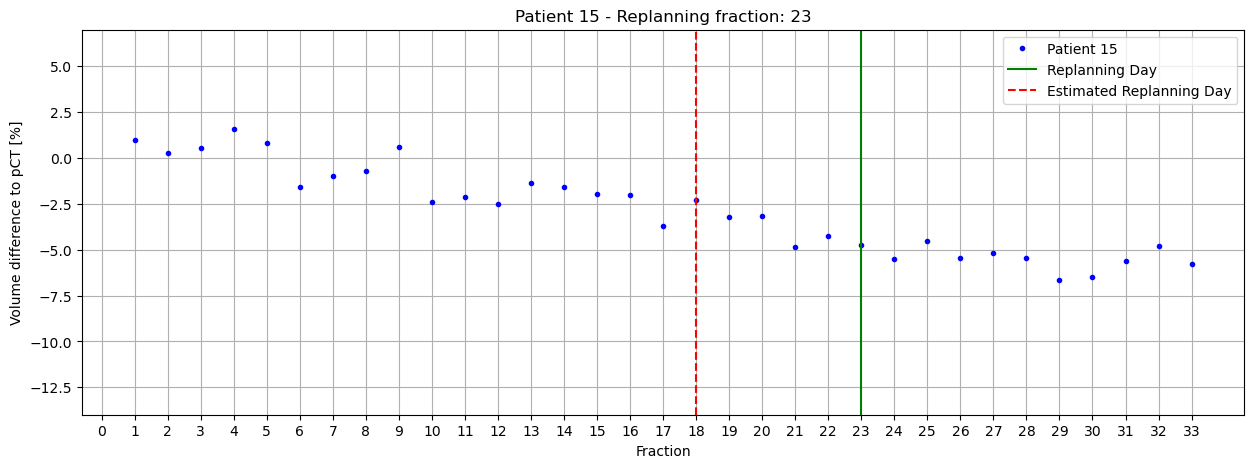

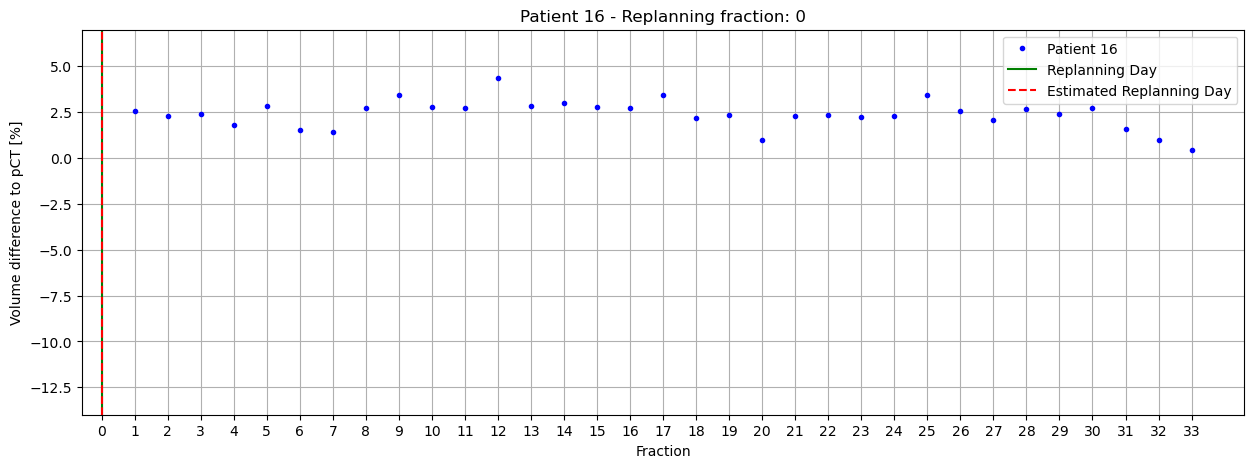

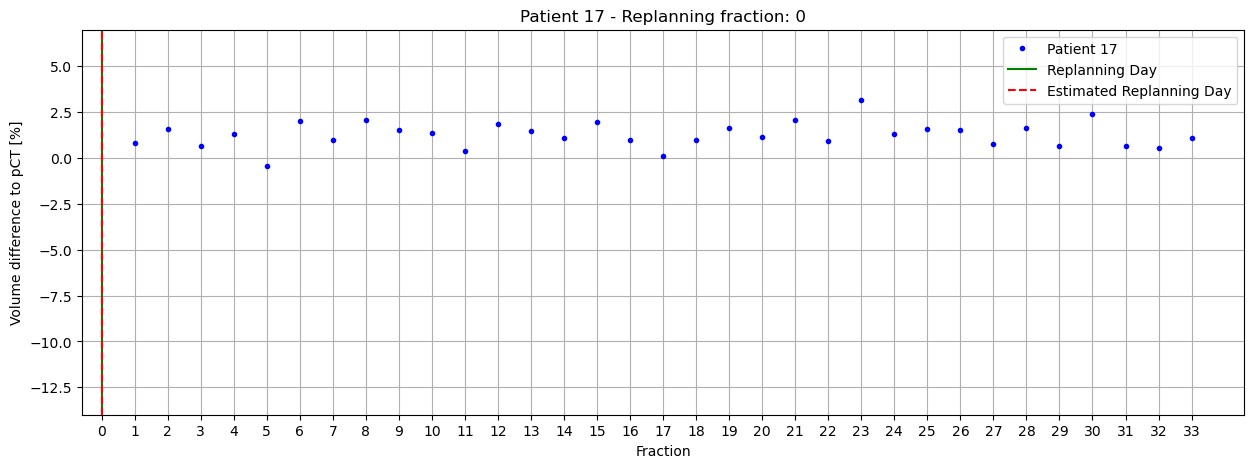

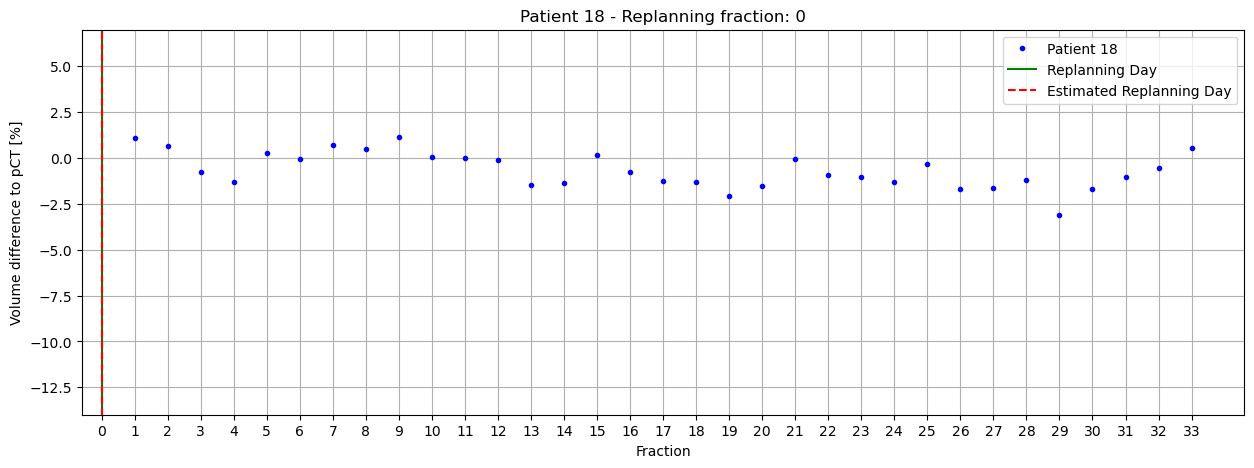

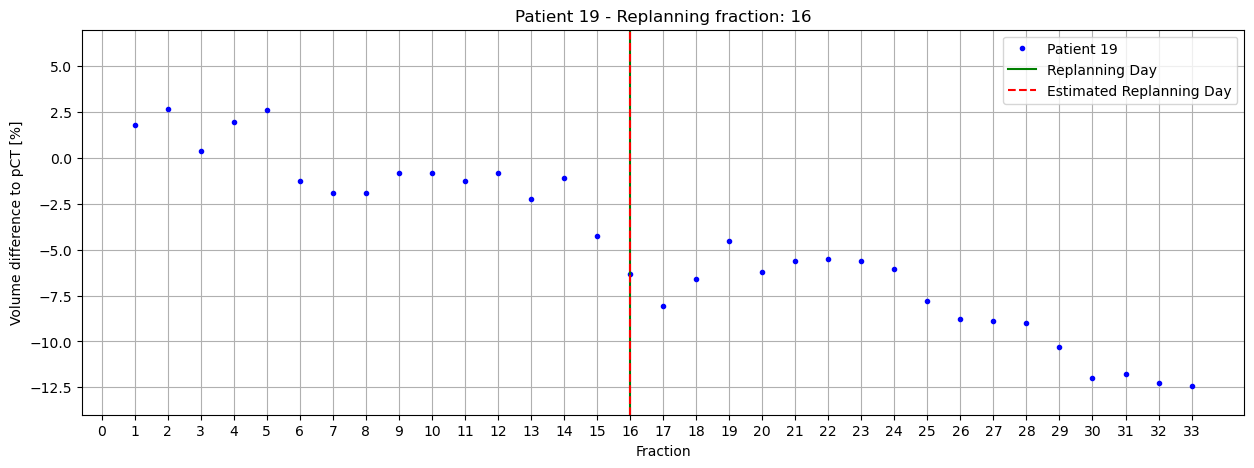

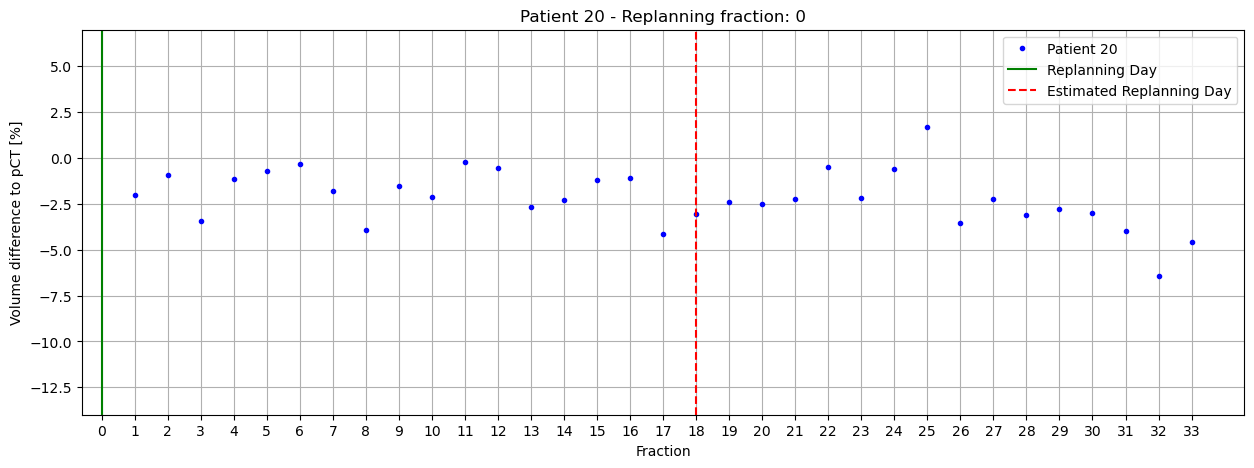

In [131]:
pred_label = final_model.predict(X_full)
y_train = [p['label'] for p in patients]
for yt, yp in zip(y_train, pred_label):
    print(f"True: {yt}, Pred: {yp}")

print(np.mean(np.array(y_train)-np.array(pred_label)))

print(f'f1: {calculate_f1(y_train, pred_label)}')
print(f'balanced acc: {calculate_balanced_accuracy(y_train, pred_label)}')
print(f'custom loss: {custom_loss(y_train, pred_label, *best_params)}')




for patient, pred in zip(patients, pred_label):
    volumes = patient['volume']
    patient_id = patient['patient_id']
    labels = patient['label']
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(1, len(volumes)+1), volumes,  'b.', label=f'Patient {patient_id}',)
    plt.title(f'Patient {patient_id} - Replanning fraction: {labels}')
    plt.xlabel('Fraction')
    plt.ylabel('Volume difference to pCT [%]')
    
    plt.axvline(x=labels, color='g', linestyle='-', label='Replanning Day')
    plt.axvline(x=pred, color='r', linestyle='--', label='Estimated Replanning Day')
    plt.xticks(np.arange(0, len(volumes)+1, 1))
    plt.ylim(-14, 7)

    plt.grid()
    plt.legend()

In [ ]:
import numpy as np
import pandas as pd
from itertools      import combinations
from sklearn.base   import clone
from sklearn.metrics import f1_score, balanced_accuracy_score
import copy

# ---------------------------------------------------------------------
# 0️⃣  --------  helper: your original F1 and any other functions  -----
# ---------------------------------------------------------------------
def calculate_f1(y_true, y_pred):
    """
    Binary F1 for 'needs-replanning' vs 'no-replanning'.
    """
    tp = fp = fn = 0
    for yt, yp in zip(y_true, y_pred):
        if yt > 0 and yp > 0:
            tp += 1
        elif yt == 0 and yp > 0:
            fp += 1
        elif yt > 0 and yp == 0:
            fn += 1
    if tp + fp + fn == 0:
        return 0.0
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall    = tp / (tp + fn) if tp + fn > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision + recall else 0


# ---------------------------------------------------------------------
# 1️⃣  --------  CONFIGURATION  (unchanged)  ---------------------------
# ---------------------------------------------------------------------
feature_variants = ['A', 'B', 'C', 'D']

model_types = {
    'THRESH': ThresholdModel(custom_loss_fn=custom_loss),   # your threshold model
    # 'RF': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    # 'LR': LogisticRegression(max_iter=1000)
}

loss_params_grid = list(                       # α_late, β_fn, γ_fp
    product([0.5, 0.7, 0.9],
            [300, 600, 900],
            [300, 600, 900])
)

# ---------------------------------------------------------------------
# 2️⃣  --------  LEAVE-2-OUT OUTER LOOP  -------------------------------
#         * all changes relative to your 5-fold code are marked *
# ---------------------------------------------------------------------
summary_rows      = []
all_patient_ids   = list(range(len(patients)))           # L2O CHANGE
all_l2o_splits    = list(combinations(all_patient_ids, 1))  # L2O CHANGE
total_folds       = len(all_l2o_splits)                  # 210 for 21 pts

print(f"Running Leave-2-Out CV on {total_folds} splits …")   # L2O CHANGE

for fold_idx, test_ids in enumerate(all_l2o_splits, 1):  # L2O CHANGE
    print(f"  fold {fold_idx}/{total_folds}...")            # L2O CHANGE
    # ✂ ------------------------------------------------------------
    # split patients
    train_ids    = [i for i in all_patient_ids if i not in test_ids]
    train_pts    = [patients[i] for i in train_ids]
    test_pts     = [patients[i] for i in test_ids]

    # keep the best config found *within this fold*
    best_f1 = 0
    best_score = float("inf")
    best_model = best_variant = best_params = best_name = None

    # -------- inner grid search on TRAIN patients only ------------
    for variant in feature_variants:
        for name, proto in model_types.items():
            for α, β, γ in loss_params_grid:
                if β <= γ:          # your guard
                    continue

                y_train = [p['label'] for p in train_pts]

                if name == 'THRESH':
                    X_train = [
                        [extract_features(p['volume'][:t], variant) for t in range(5, 31)]
                        for p in train_pts
                    ]
                    model = clone(proto)
                    model.alpha_late, model.beta_fn, model.gamma_fp = α, β, γ
                    model.fit(X_train, y_train)
                    y_pred_train = model.predict(X_train)
                else:
                    X_train = [extract_features(p['volume'], variant) for p in train_pts]
                    model   = clone(proto).fit(X_train, y_train)
                    y_pred_train = model.predict(X_train)

                score = custom_loss(y_train, y_pred_train, α, β, γ)
                f1    = calculate_f1(y_train, y_pred_train)

                # keep best by F1 then custom loss
                if f1 > best_f1 or (f1 == best_f1 and score < best_score):
                    best_f1, best_score = f1, score
                    best_model   = copy.deepcopy(model)
                    best_variant = variant
                    best_params  = (α, β, γ)
                    best_name    = name

    # -------- evaluate on TWO held-out test patients -------------
    y_true, y_pred, t_detect = [], [], []

    for patient in test_pts:
        y_true.append(patient['label'])

        if best_name == 'THRESH':
            seq = [extract_features(patient['volume'][:t], best_variant) for t in range(5, 31)]
            pred = best_model.predict([seq])[0]
            t_detect.append(pred)
            y_pred.append(pred)
        else:
            feat = extract_features(patient['volume'], best_variant)
            pred = best_model.predict([feat])[0]
            y_pred.append(pred)
            t_detect.append(0 if pred == 0 else 30)

    summary_rows.append({
        'fold'            : fold_idx,                     # L2O CHANGE
        'test_patients'   : test_ids,                     # L2O CHANGE
        'model'           : best_name,
        'features'        : best_variant,
        'params'          : best_params,
        'custom_loss'     : custom_loss(y_true, y_pred, *best_params),
        'f1_macro'        : f1_score(y_true, y_pred, average='macro'),
        'balanced_acc'    : balanced_accuracy_score(y_true, y_pred),
        'avg_detect_t'    : np.mean([t for t in t_detect if t > 0]) if any(t>0 for t in t_detect) else 0
    })

    # small progress log
    if fold_idx % 25 == 0 or fold_idx == total_folds:    # L2O CHANGE
        print(f"  finished {fold_idx}/{total_folds} L2O folds")

# ---------------------------------------------------------------------
# 3️⃣  --------  RESULTS ACROSS 210 FOLDS  ----------------------------
# ---------------------------------------------------------------------
summary_df = pd.DataFrame(summary_rows)
display(summary_df)

print("\nAverage F1  over L2O folds :", summary_df['f1_macro'].mean())
print("Average loss over L2O folds :", summary_df['custom_loss'].mean())


Running Leave-2-Out CV on 21 splits …
  fold 1/21...
  fold 2/21...
  fold 3/21...
  fold 4/21...
  fold 5/21...
  fold 6/21...
  fold 7/21...
  fold 8/21...
  fold 9/21...
  fold 10/21...
  fold 11/21...
  fold 12/21...
  fold 13/21...
  fold 14/21...
  fold 15/21...
  fold 16/21...
  fold 17/21...
  fold 18/21...
  fold 19/21...
  fold 20/21...
  fold 21/21...
  finished 21/21 L2O folds


,fold,test_patients,model,features,params,custom_loss,f1_macro,balanced_acc,avg_detect_t
0,1,"(0,)",THRESH,D,"(0.7, 900, 600)",2.7,0.0,0.0,5.0
1,2,"(1,)",THRESH,D,"(0.9, 600, 300)",300.0,0.0,0.0,0.0
2,3,"(2,)",THRESH,B,"(0.5, 600, 300)",24.5,0.0,0.0,10.0
3,4,"(3,)",THRESH,D,"(0.7, 600, 300)",2.7,0.0,0.0,19.0
4,5,"(4,)",THRESH,B,"(0.9, 600, 300)",300.0,0.0,0.0,0.0
5,6,"(5,)",THRESH,D,"(0.9, 900, 600)",8.1,0.0,0.0,10.0
6,7,"(6,)",THRESH,C,"(0.5, 600, 300)",0.5,0.0,0.0,11.0
7,8,"(7,)",THRESH,D,"(0.9, 600, 300)",16.9,0.0,0.0,8.0
8,9,"(8,)",THRESH,B,"(0.9, 600, 300)",14.4,0.0,0.0,5.0
9,10,"(9,)",THRESH,D,"(0.7, 600, 300)",76.8,0.0,0.0,10.0



Average F1  over L2O folds : 0.23809523809523808
Average loss over L2O folds : 166.96190476190478
